In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

In [3]:
fname = "2020_10_1.hdf"
dset_name = "1601575396 shutter rc off resonance"
title = "shutter rotational cooling laser off resonance"

dset_names = [dset_name]
devices = ('Laser Lock', 'Wavelength', 'ZaberTMM')

In [4]:
pmt_channel = 1
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [5]:
qswitch_fired = []
qswitch_not_fired = []
for key, val in pxie.items():
    if np.max(val[:,0]) > 500:
        qswitch_fired.append(key)
    else:
        qswitch_not_fired.append(key)
qswitch_fired.sort()
qswitch_not_fired.sort()

In [6]:
ch = 1
powers = np.linspace(5,6.5,7)
indices_grouped = {p: {'open': [], 'closed': []} for p in powers}
data_grouped = {p: {'open': [], 'closed': []} for p in powers}

for idx in qswitch_fired:
    attrs = pxie_attrs[idx]
    p = attrs['Seed1Amplifier SetCurrent']
    if attrs['ShutterControl SetVoltage'] == '0':
        indices_grouped[p]['closed'].append(idx)
        data_grouped[p]['closed'].append(pxie[idx][:,ch])
    elif attrs['ShutterControl SetVoltage'] == '5':
        indices_grouped[p]['open'].append(idx)
        data_grouped[p]['open'].append(pxie[idx][:,ch])

5.0 A -> integral ratio : 1.05792 +/- 0.05900
5.2 A -> integral ratio : 1.00930 +/- 0.05315
5.5 A -> integral ratio : 1.05629 +/- 0.06902
5.8 A -> integral ratio : 0.96381 +/- 0.06119
6.0 A -> integral ratio : 0.94810 +/- 0.05826
6.2 A -> integral ratio : 0.98782 +/- 0.06567
6.5 A -> integral ratio : 1.00765 +/- 0.08524


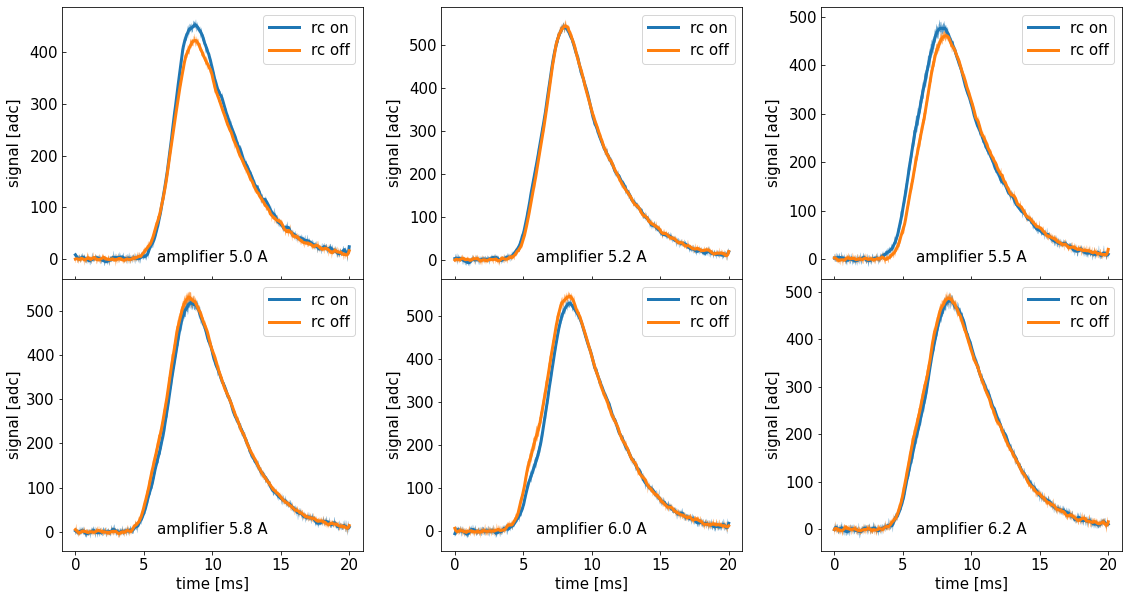

In [7]:
from scipy.signal import savgol_filter

figf, axf = plt.subplots(2,3,figsize = (19,10), sharex = True, 
            gridspec_kw={'hspace': 0, 'wspace': .26, 'height_ratios': [1,1]})

axp = {p:ax for p,ax in zip(powers, axf.flatten())}

ratios = []

for p in powers:
    yo = np.mean(data_grouped[p]['open'], axis = 0)
    yc = np.mean(data_grouped[p]['closed'], axis = 0)
    yo -= np.mean(yo[:300])
    yc -= np.mean(yc[:300])

    lo = len(data_grouped[p]['open'])
    lc = len(data_grouped[p]['closed'])

    syo = np.std(data_grouped[p]['open'], axis = 0)
    syo /= np.sqrt(lo)
    syc = np.std(data_grouped[p]['closed'], axis = 0)
    syc /= np.sqrt(lc)

    x = np.linspace(0,1999,2000)/100
    
    trapzo = np.trapz(-yo)
    trapzc = np.trapz(-yc)
    trapz_error = (trapzo/trapzc)*np.sqrt((np.sum(syo)/trapzo)**2 + (np.sum(syc)/trapzc)**2)
    
    ratios.append((np.trapz(-yo)/np.trapz(-yc), trapz_error))
    
    print(f'{p:.1f} A -> integral ratio : {np.trapz(-yo)/np.trapz(-yc):.5f} +/- {trapz_error:.5f}')
    
    if p in axp:
        axp[p].fill_between(x, -yo-syo, -yo+syo, alpha = .7)
        axp[p].fill_between(x, -yc-syc, -yc+syc, alpha = .7)
        axp[p].plot(x, -savgol_filter(yo, 51, 3), lw = 3, label= 'rc on')
        axp[p].plot(x, -savgol_filter(yc, 51, 3), lw = 3, label = 'rc off')
        axp[p].set_xlabel('time [ms]')
        axp[p].set_ylabel('signal [adc]')
        axp[p].text(0.5, 0.05, f'amplifier {p:.1f} A', transform=axp[p].transAxes, fontsize = 15,
                   ha = 'center', va = 'bottom')
        
        axp[p].legend(fontsize = 15)
        set_fontsize(axp[p], 15)
for ax in list(axp.values())[:len(axp)//2]:
    ax.tick_params(direction = 'in')

figf.align_ylabels()
    
# figf.savefig(f'linearity.png', dpi = 300, bbox_inches='tight')

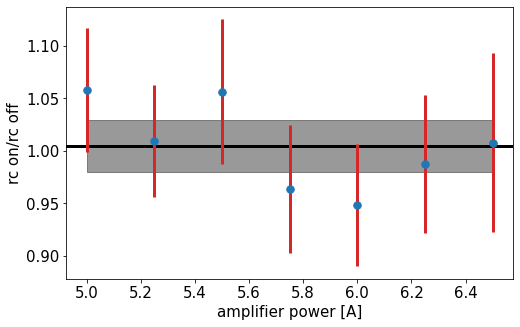

In [8]:
y,yerr = zip(*ratios)

ymean = np.mean(y)
yerr = np.array(yerr)
ymeanerr = np.sqrt(np.sum(yerr**2))/len(yerr)

fig, ax = plt.subplots(figsize = (8,5))

ax.errorbar(powers, y, yerr, fmt = '.', ms = 15, ecolor = 'C3', lw = 3)
ax.axhline(ymean, color = 'k', lw = 3, zorder = 0)
ax.fill_between(powers, ymean - ymeanerr, ymean+ymeanerr, zorder = 0, alpha = 0.4, color = 'k')

ax.set_ylabel('rc on/rc off')
ax.set_xlabel('amplifier power [A]')

set_fontsize(ax, 15)

In [9]:
investigate = []
integrals = []
for idx in qswitch_fired:
    y = pxie[idx][:,ch]
    integral = np.trapz(-(y-np.mean(y[:300])))
    integrals.append(integral)
    if integral < 7e4:
        investigate.append(idx)

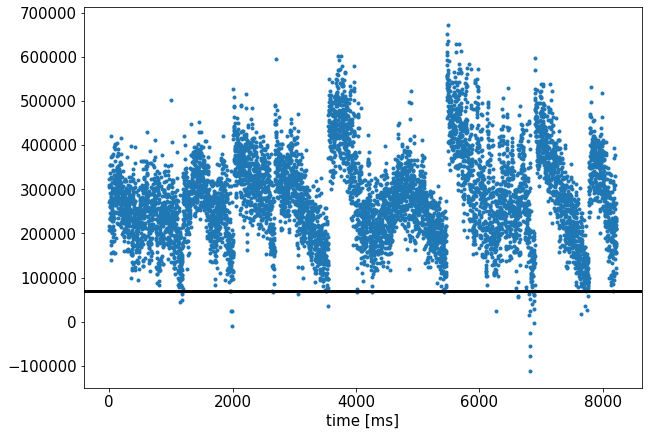

In [10]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(integrals, '.')

ax.set_xlabel('time [ms]')

ax.axhline(7e4, color = 'k', lw = 3)

set_fontsize(ax, 15)

42 shots with small integral


<ipython-input-11-a565c5330c59>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (10,7))


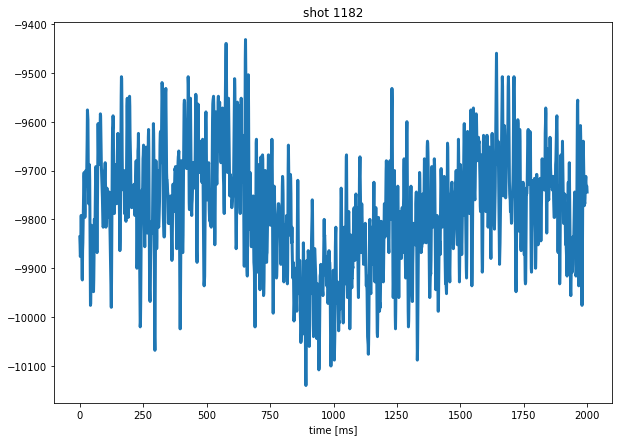

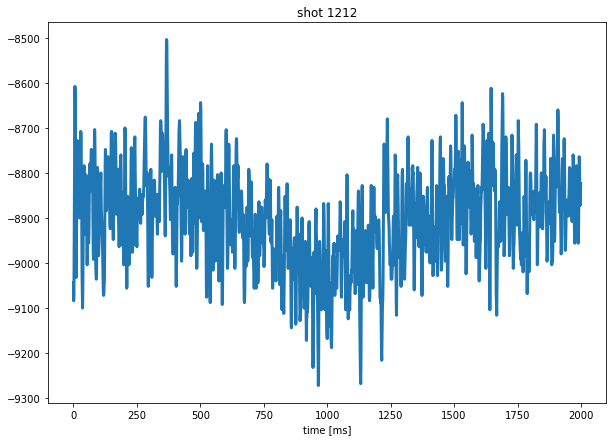

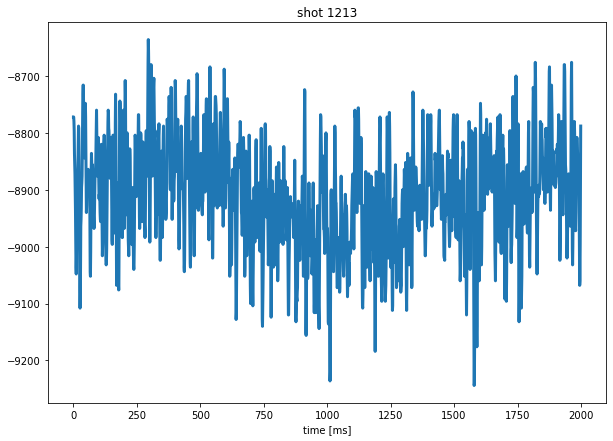

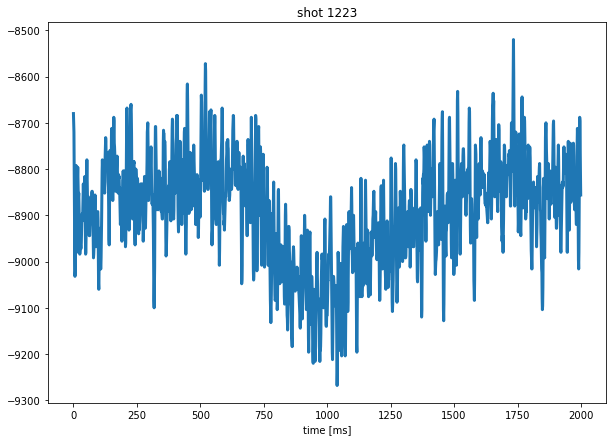

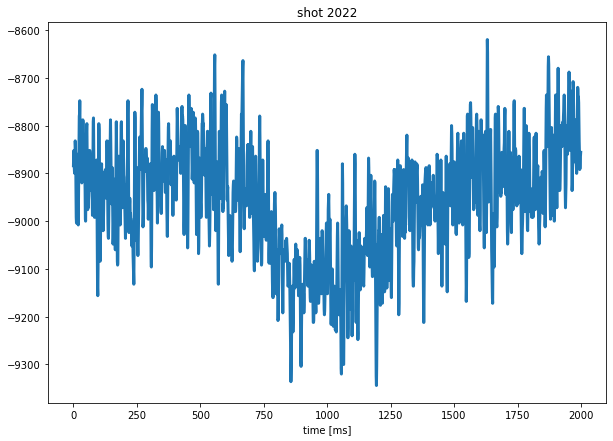

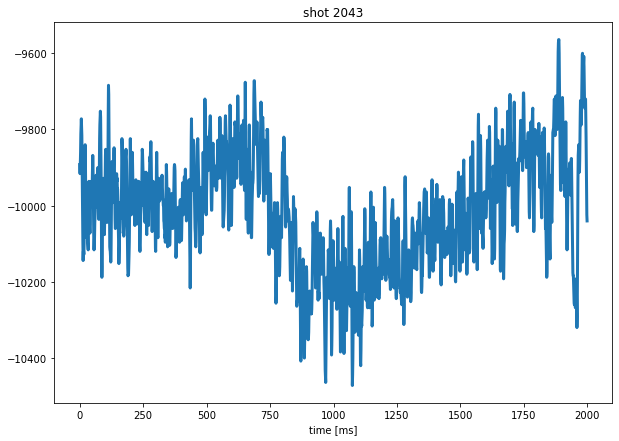

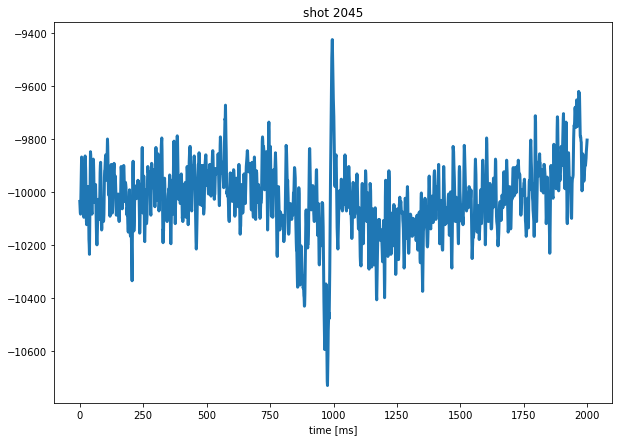

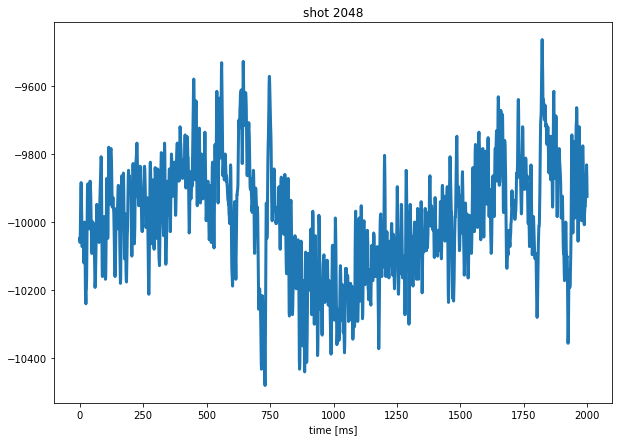

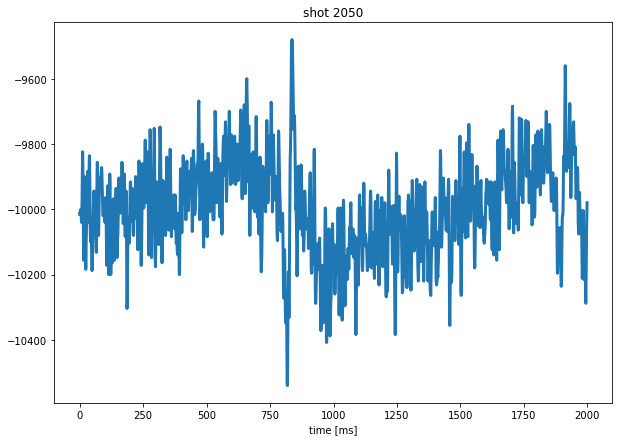

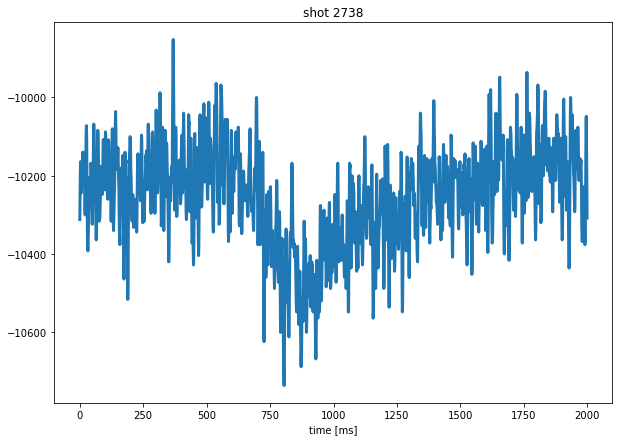

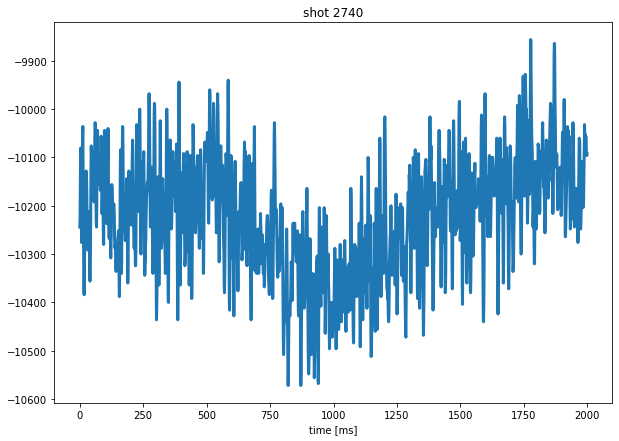

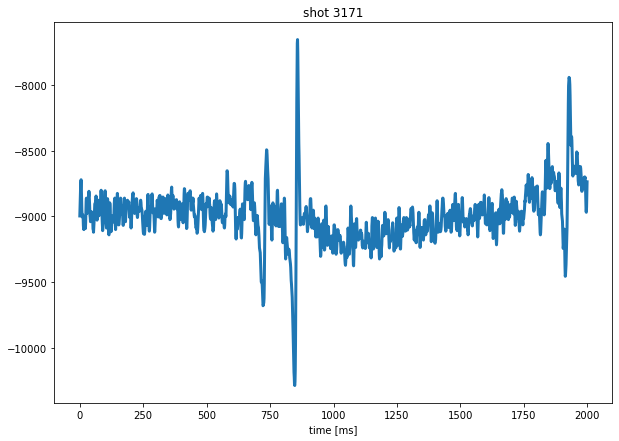

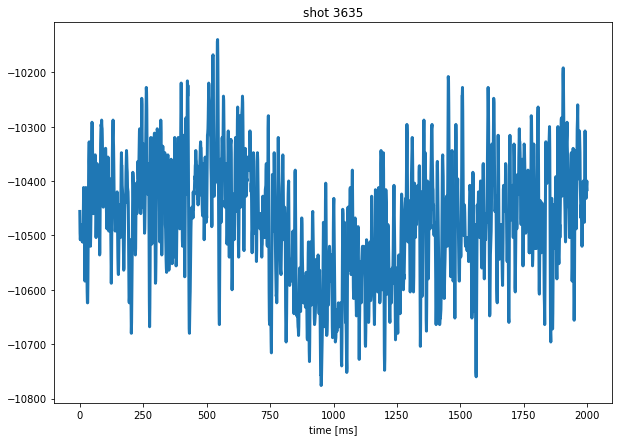

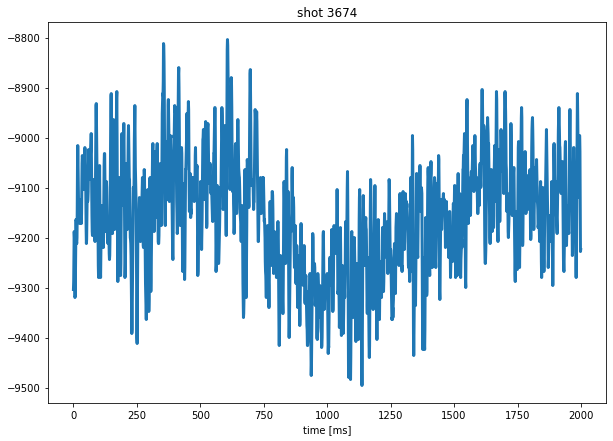

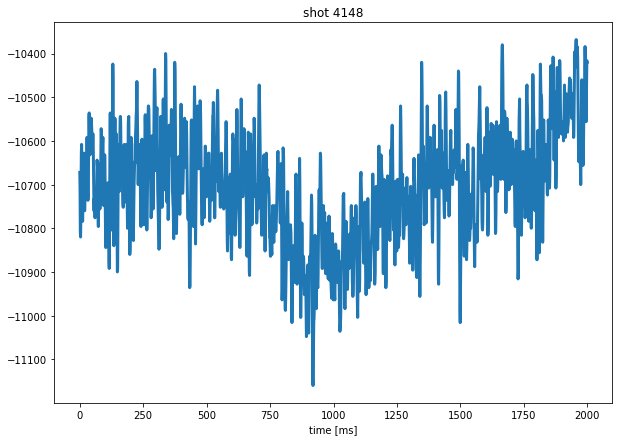

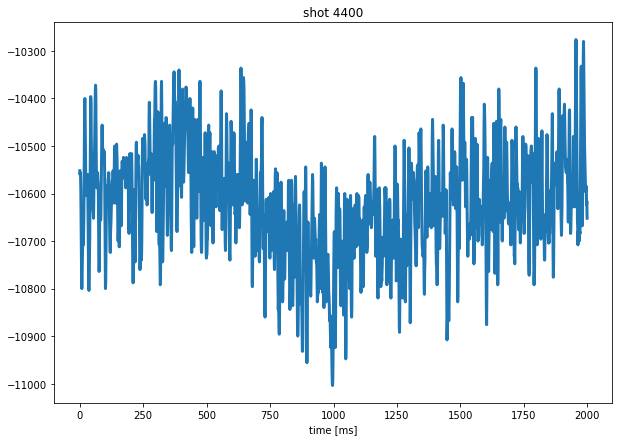

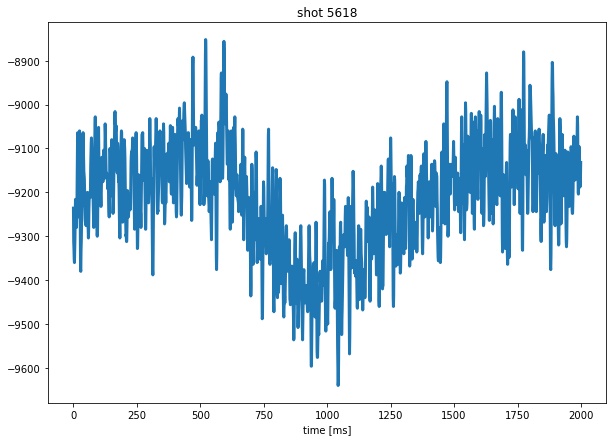

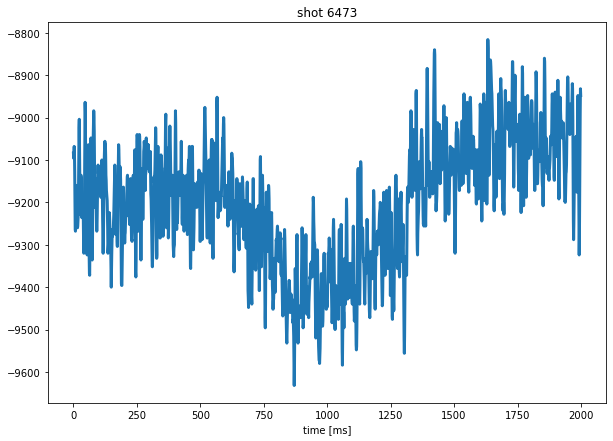

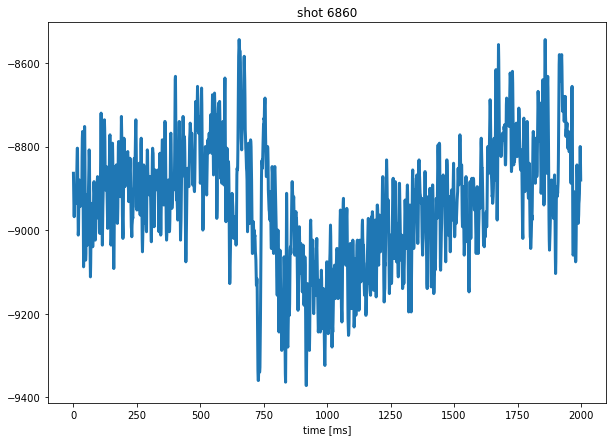

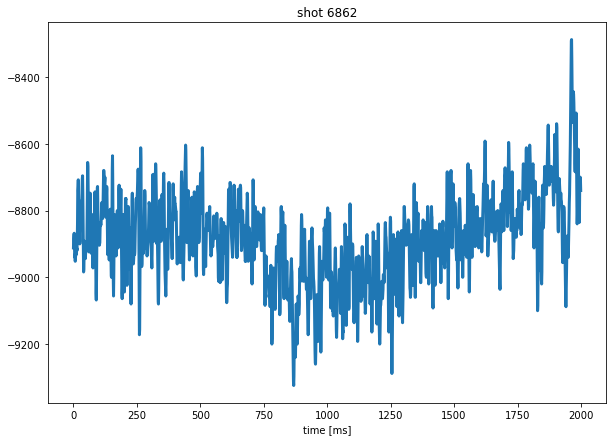

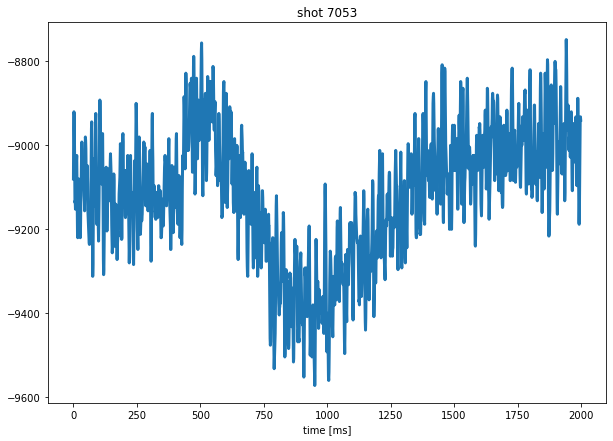

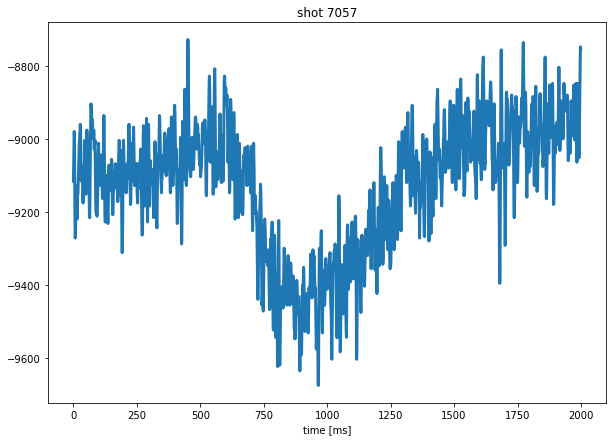

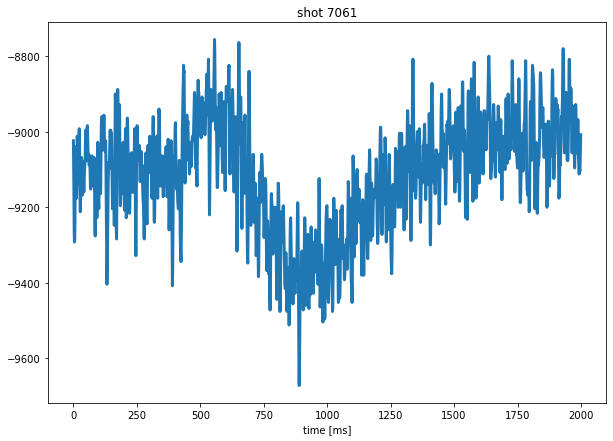

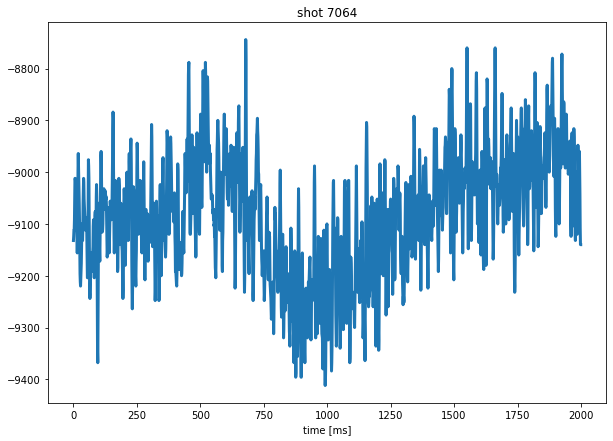

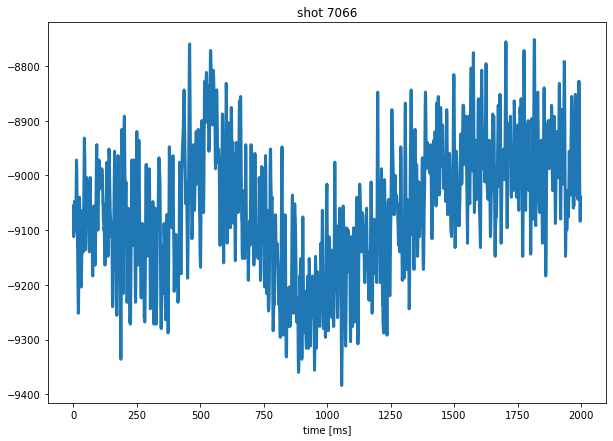

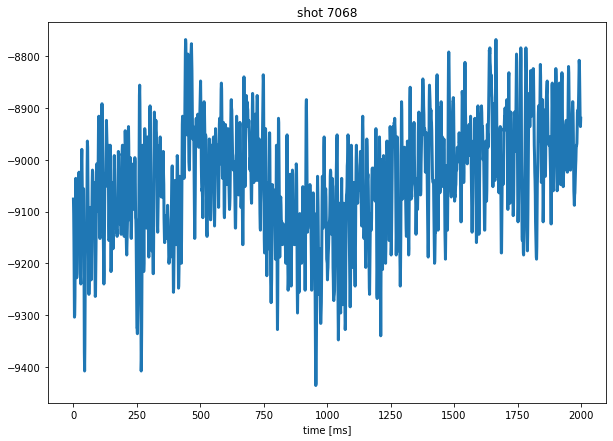

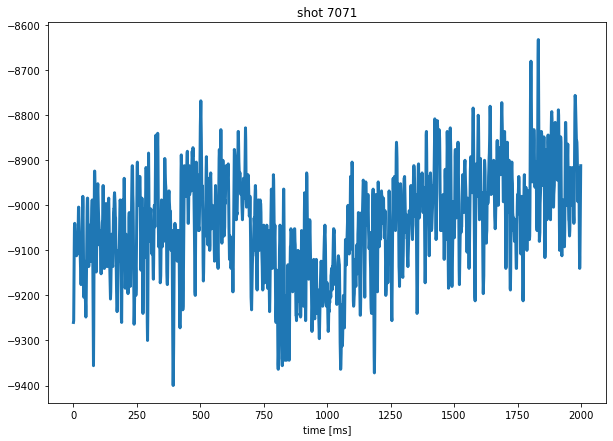

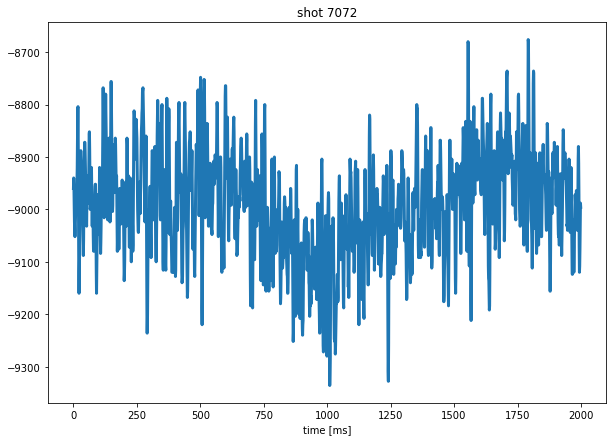

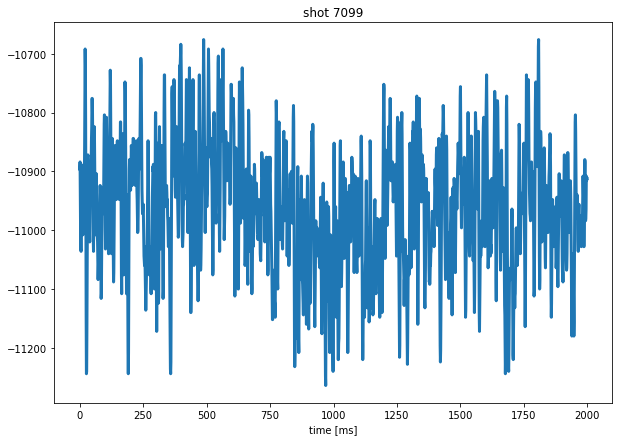

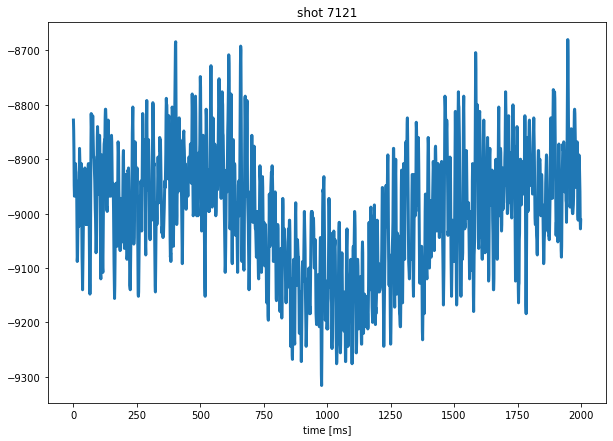

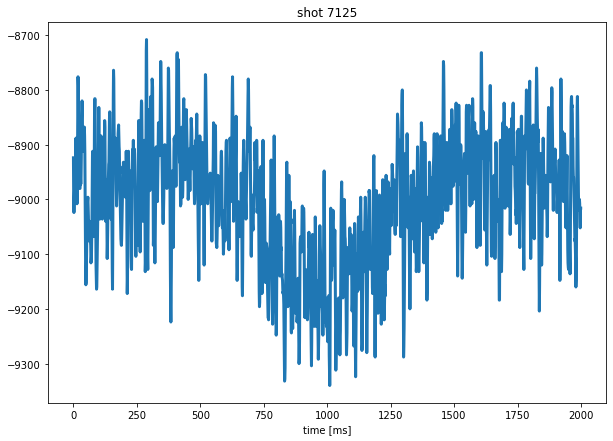

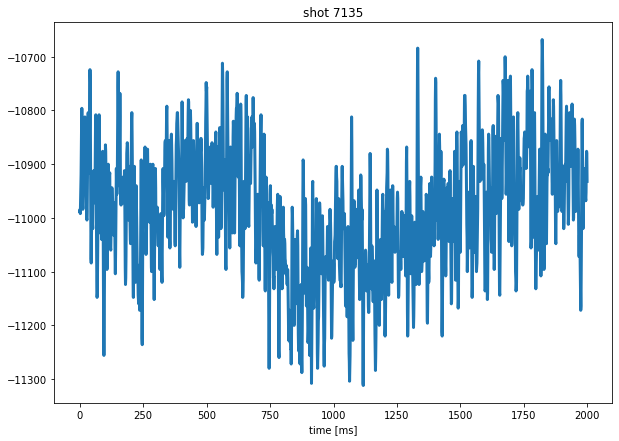

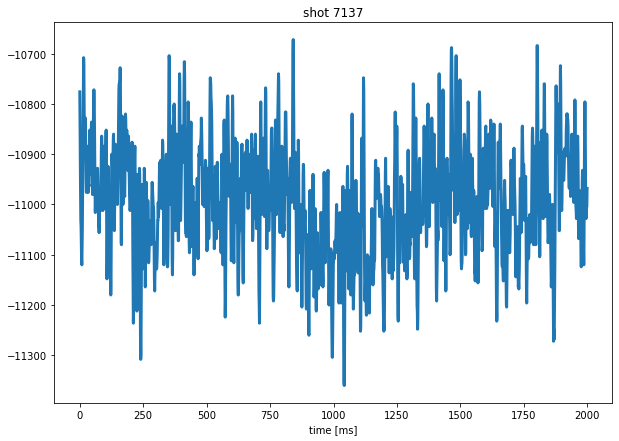

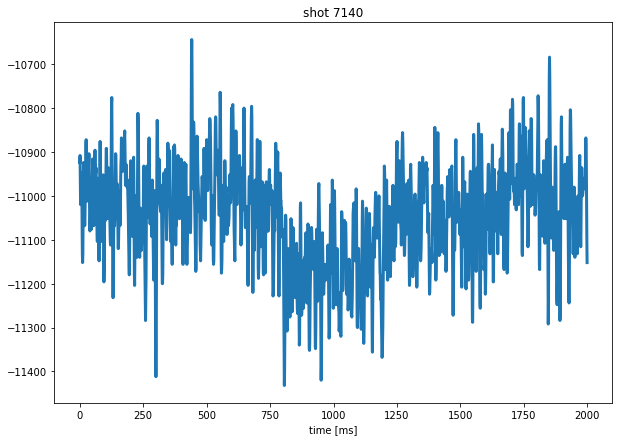

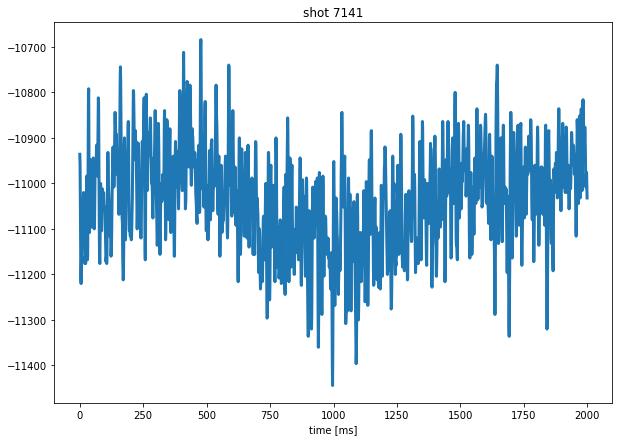

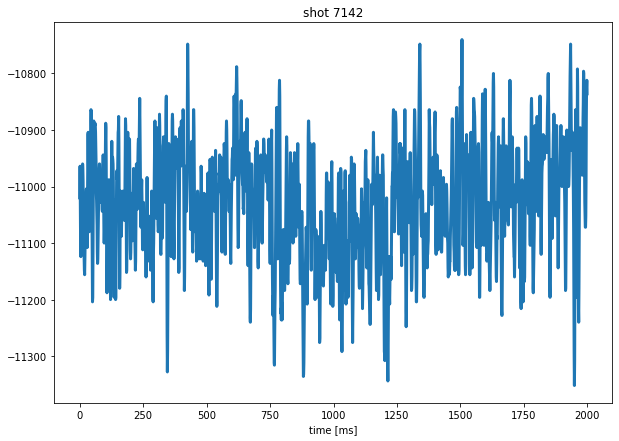

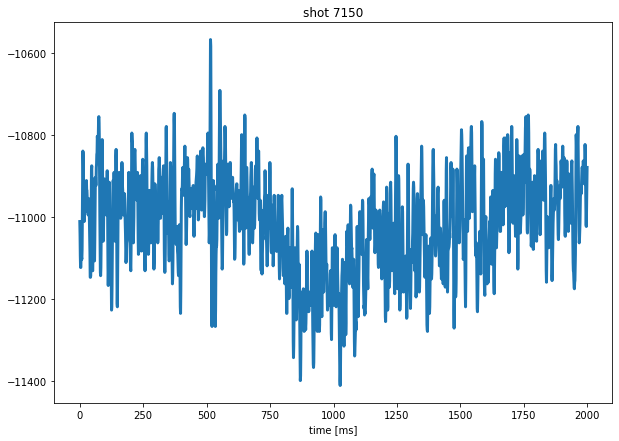

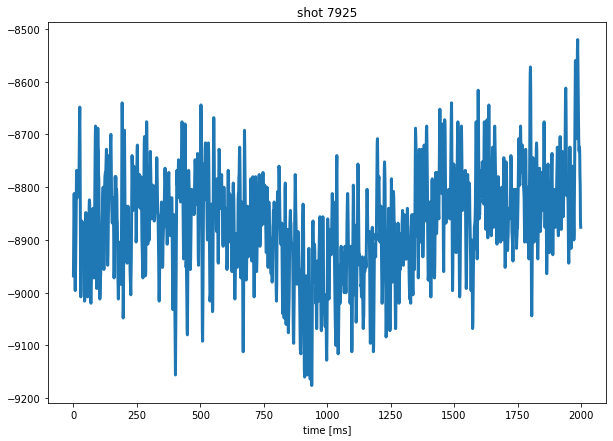

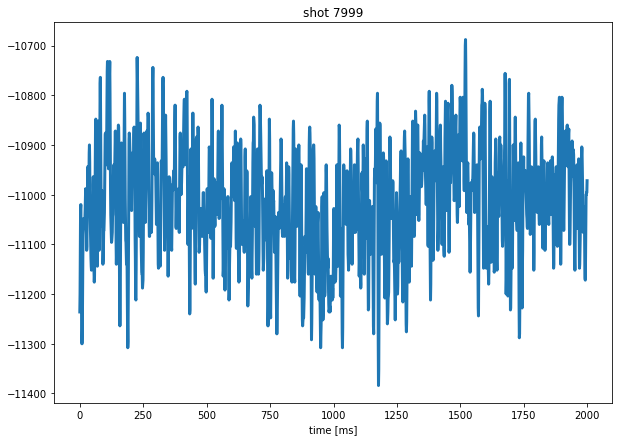

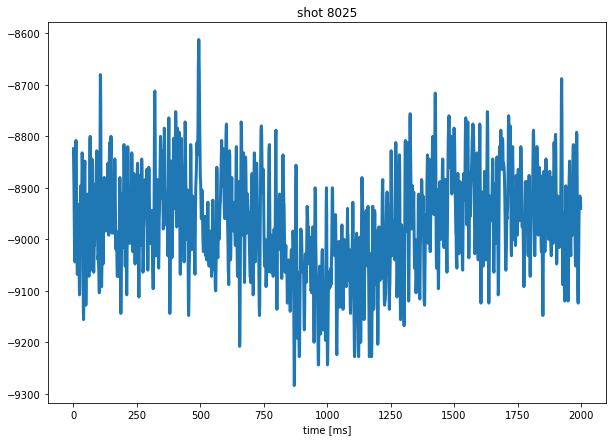

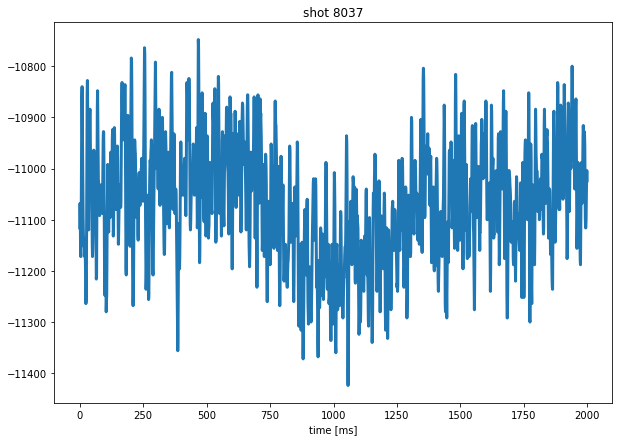

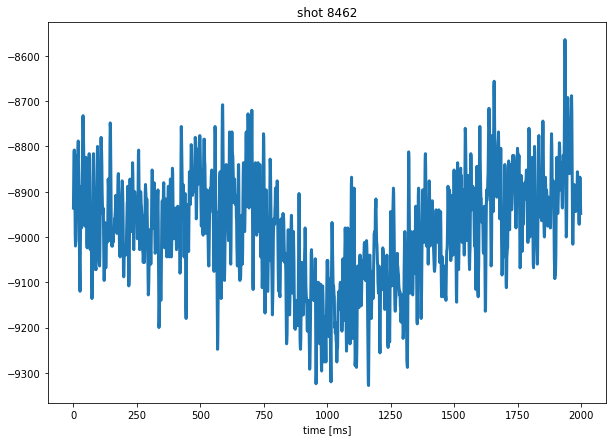

In [11]:
print(f'{len(investigate)} shots with small integral')
for idx in investigate:
    fig, ax = plt.subplots(figsize = (10,7))
    ax.plot(pxie[idx][:,ch], lw = 3)
    
    ax.set_title(f'shot {idx}')

    ax.set_xlabel('time [ms]')